In [1]:
import os
from pathlib import Path
import IPython.display as ipd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
%matplotlib inline

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#from subprocess import check_output
#print(check_output(["dir", "../input"]).decode("utf8"))

Using TensorFlow backend.


# View the Data

In [2]:
folders = os.listdir("D:/ML/Voice2Text/Kaggle/Data/train/audio/")
print(folders)

['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [3]:
train_path = "D:/ML/Voice2Text/Kaggle/Data/train/audio/"
train_labels = os.listdir(train_path)
train_labels.remove('_background_noise_') #removes item from list
print(train_labels)



['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


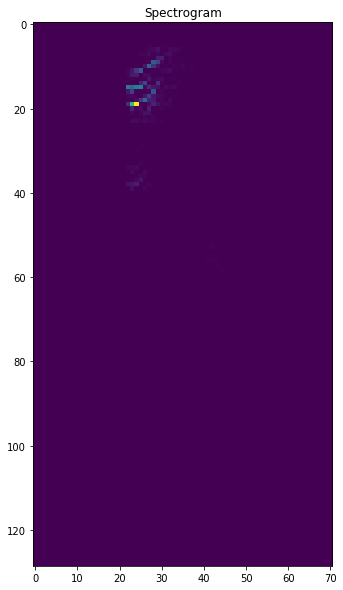

In [4]:
sample_rate, samples = wavfile.read(str(train_path) + '/house/00b01445_nohash_0.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
ax1.set_title('Spectrogram')
ax1.imshow(spectrogram)
fig.savefig('spec.png',bbox_inches=None)

# Clean the data 

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.06it/s]


(array([1.200e+01, 2.000e+01, 1.800e+02, 1.590e+02, 3.760e+02, 6.480e+02,
        9.670e+02, 8.000e+02, 1.419e+03, 6.014e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <a list of 10 Patch objects>)

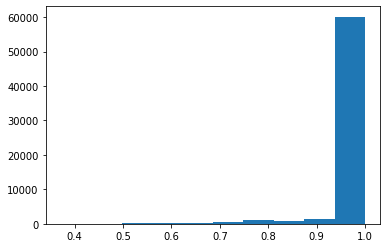

In [5]:
recording_len = []
for folder in tqdm(train_labels):
    cur_path = train_path + folder
    for file in os.listdir(cur_path):
        sample_rate, samples = wavfile.read(cur_path +'/'+ file)
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
        recording_len.append(len(samples)/sample_rate)

plt.hist(np.array(recording_len))

In [6]:
spec_data = []
name_data = []
for folder in tqdm(train_labels):
    cur_path = train_path + folder
    for file in os.listdir(cur_path):
        sample_rate, samples = wavfile.read(cur_path +'/'+ file)
        length = len(samples)/sample_rate
        if(length == 1):
            frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
            spec_data.append(spectrogram)
            name_data.append(folder)
        

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:54<00:00,  1.81s/it]


In [7]:
print("Number of data entries is", len(spec_data))
print("Number of labels is", len(name_data))

Number of data entries is 58252
Number of labels is 58252


In [8]:
le = LabelEncoder()
y = le.fit_transform(name_data)
classes= list(le.classes_)
print(classes)


y=np_utils.to_categorical(y, num_classes=len(classes))

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [9]:
x = np.array(spec_data)
x = x.reshape([-1,129, 71,1])

print('y shape is',y.shape)
print('x shape is',x.shape)

y shape is (58252, 30)
x shape is (58252, 129, 71, 1)


In [10]:
from sklearn.model_selection import train_test_split
x_tr, x_tes, y_tr, y_tes = train_test_split(x, y,test_size = 0.10,random_state=42,shuffle=True)

# Creating a Neural Network

In [14]:
from tensorflow.keras.models import load_model
from PIL import Image as PImage
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D 
from keras import backend as K
import tensorflow

from os import listdir
import os, os.path

In [19]:
def buildModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(129, 71,1)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    

    model.add(Dense(len(classes), activation='softmax'))
   
    model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    model.summary()
    return model

In [20]:
K.clear_session()
model = buildModel()
results = model.fit(x_tr, y_tr, batch_size=32, epochs=40, validation_split=0.25, verbose=2, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 129, 71, 32)       320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 71, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 129, 71, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 35, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 35, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 35, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 35, 64)       

In [ ]:
plt.plot(results.history['loss'], label='train') 
plt.plot(results.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
plt.plot(results.history['accuracy'], label='train') 
plt.plot(results.history['val_accuracy'], label='test') 
plt.legend() 
plt.show()

In [20]:
model.save('Voice2TextV2.h5')

In [21]:
def R2_SoftHot(y1, y2):
    correct = 0
    if(y1.shape[0] == y2.shape[0]):
        for size in range(y1.shape[0]):
            y11 = np.argmax(y1[size], axis=0)
            y22 = np.argmax(y2[size], axis=0)
            if(y11 == y22):
                correct = correct + 1
        result = correct/y1.shape[0]
    else:
     print("Miss matched size")
    return result

In [22]:
R2_SoftHot(y_tes, model.predict(x_tes))

0.8462066598008926